# Direct Regression

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat
import re
import string
import sklearn
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from tqdm import tqdm_notebook as tqdm
#from cinspect import dependence, importance
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import r2_score
import pickle
import time

from reed import drop_missing_treatment_or_outcome, Model

# set global notebook options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Response Model

How well can we predict outcomes $Y$ conditional on treatment $T$ and other covariates $Z$?

### Treatent variables

   - **reduhl**	Completed re-education based on highest level of attainment
   - **redudl**	Completed re-education based on detailed qualifications
   - **redufl**	Completed re-education using highest lvl and detailed qualifications.

### Outcome variables
   - Mental health in 2019 (**mh**). This is the transformed mental health scores from the aggregation of mental health items of the SF-36 Health Survey, as reported by the individual in 2019. It ranges from 0 to 100, with higher scores indicating better mental health.  
   - Working hours in 2019 (**wkhr**) records the total number of hours the individual works in all jobs in a week on average. Working hours are set to 0 for those not working. 
   - Hourly Wages in 2019 (**rlwage**) records the average hourly wage for the individual’s main job in 2019. Hourly wages are set to 0 for those not working and set to missing for those reporting working more than 100 hours a week. 
   
#### Columns explicitly excluded
   - **xwaveid** (unique identifier)
   - **p_rcom*** (timing of completion of re-education, proxies treatment) TODO think about how we would include this
   - **p_cotrl** (first avail 2003)
   - **p_rdf*** (first avail 2012)

#### Select modeling parameters

In [2]:
outcome = 'y_Dwsce'#'y_wsce'
treatment = 'redufl'
optimisation_metric = 'neg_mean_squared_error'
evaluation_metrics = ('r2','neg_mean_squared_error')
log_outcome=False
cross_val_cache = "data/cross-val-all-lasso.pkl"#"data/cross-val-all.pkl"
bootstrap_cache = "data/bootstrap-all-lasso.pkl"#"data/bootstrap-all.pkl"
data_file = "all_lasso_selected_20.csv"#"all_vars.csv"

### Load Data 
   - drop rows missing the specified treatment or outcome

In [3]:
data = pd.read_csv(data_file,index_col='xwaveid')
drop_missing_treatment_or_outcome(data, treatment, outcome)
if log_outcome:
    data[outcome] = np.log(data[outcome]+data[outcome].min())

Dropped 592 rows missing treatment or outcome.


In [4]:
from direct_regression import seperate_and_transform_data
X0, X1, y0, y1, X, y, t, features = seperate_and_transform_data(data, treatment, outcome)

print("Control data dimensions: ",X0.shape)
print("Treated data dimensions:",X1.shape)


Control data dimensions:  (3659, 20)
Treated data dimensions: (1295, 20)


### Set up models
Specify which models to use and the hyper-parameter space to search over for each

## Modelling, using causal-inspect package

In [5]:
from cinspect.model_evaluation import bootstrap_model, eval_model
from cinspect.evaluators import BinaryTreatmentEffect
from cinspect.estimators import BinaryTreatmentRegressor
from cinspect.dimension import effective_rank
from sklearn.model_selection import GridSearchCV, RepeatedKFold, ShuffleSplit, GroupKFold

In [6]:
X_frame = pd.DataFrame(X, columns=[f"x{i}" for i in range(X.shape[1])])
X_frame['T'] = t
Y = y

ridge_gs = GridSearchCV(Ridge(), param_grid={"alpha": np.logspace(-1,4,5)})
mod = BinaryTreatmentRegressor(ridge_gs, "T", 1.)

results = {}

 # Casual estimation -- Bootstrap
bteval = BinaryTreatmentEffect(treatment_column="T")  # all data
bootstrap_model(mod, X_frame, Y, [bteval], replications=30)
results["Bootstrap"] = (bteval.ate, bteval.ate_ste)

# Casual estimation -- KFold
bteval = BinaryTreatmentEffect(treatment_column="T",evaluate_mode="test")
eval_model(mod, X_frame, Y, [bteval],RepeatedKFold(n_splits=10, n_repeats=3))
results["KFold"] = (bteval.ate, bteval.ate_ste)

# Casual estimation -- ShuffleSplit
bteval = BinaryTreatmentEffect(treatment_column="T",evaluate_mode="test")
eval_model(mod, X_frame, Y, [bteval], ShuffleSplit(n_splits=30))
results["ShuffleSplit"] = (bteval.ate, bteval.ate_ste)

# Causal estimation -- Bootstrap Group

# We have to make sure we use GroupKFold with GridSearchCV here so we don't
    # get common samples in the train and test folds
ridge_gs_g = GridSearchCV(Ridge(),param_grid={"alpha": np.logspace(-1,4,5)},cv=GroupKFold(n_splits=5))
btr = BinaryTreatmentRegressor(ridge_gs_g, "T", 1.)
bteval = BinaryTreatmentEffect(treatment_column="T")  # all data used
bootstrap_model(btr, X_frame, Y, [bteval], replications=30, groups=True)
results["Bootstrap-group"] = (bteval.ate, bteval.ate_ste)



In [7]:
results

{'Bootstrap': (15.714110960827453, 30.28808440061037),
 'KFold': (20.169021836594602, 13.613749109810312),
 'ShuffleSplit': (19.800530335696966, 18.755218561159385),
 'Bootstrap-group': (26.67225926046655, 36.55657957989077)}

## Modelling

In [8]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from direct_regression import importance_from_coef

def construct_models():
    models = [
        Model('ridge',Ridge(), 
              parameters = {
                  'alpha':np.logspace(-1,4,30)
              },
              importance_func=importance_from_coef
        ),
        Model('lasso',Lasso(),
              parameters = {
                  'alpha':np.logspace(-2,4,30)
              },
              importance_func=importance_from_coef
        ),
        Model('linear',LinearRegression())
#         Model('gbr',GradientBoostingRegressor(n_iter_no_change=20, max_depth=2),
#               parameters = {
#                 'max_features':np.linspace(0,1,6)[1:],
#                 'learning_rate':np.logspace(-3,0,10),
#                 'min_samples_leaf':np.logspace(0,3,10).astype(int)
#               }
#         ),
    ]
    return models


### Prepare data for modeling
   - split into treated/control
   - impute missing values and scale
   - separate features from outcomes&treatments

### Compute unconditional/unadjusted estimate of treatment effect

In [9]:
from direct_regression import print_unconditional_effects
print_unconditional_effects(data, treatment, y0, y1)

Proportion Treated:26%
Average outcome under Control:67.85±15.36
Average outcome under Treatment:310.57±29.39
Unadjusted treatment estimate 242.72


## Checking cv objects

In [7]:
from sklearn.utils import shuffle
from sklearn.model_selection import GroupKFold
import numpy as np
from bootstrap import shuffled_samples

random_state = 42


Xv = np.arange(20).reshape((10,2))
yv = np.arange(10)
groupsv = np.array([0,0,0,1,2,3,4,5,6,7])


def cv(X, y, groups, random_state):
    
    for i, s in enumerate(shuffled_samples(len(y),3)):
        Xs, ys, gs = X[s,:], y[s], groups[s]
    
        print("Sample:",i)
        cv_out = GroupKFold(n_splits=2)
        cv_out_splits = cv_out.split(Xs, ys, gs)
        for fold, (train, test) in enumerate(cv_out_splits):
            print ("Fold:",fold)
            print ("test instances", ys[test])
            print ("test groups", gs[test])
            print ("train groups", gs[train])
            print ("***")
cv(Xv, yv, groupsv, random_state);

Sample: 0
Fold: 0
test instances [6 4 0 2 1]
test groups [4 2 0 0 0]
train groups [6 7 1 5 3]
***
Fold: 1
test instances [8 9 3 7 5]
test groups [6 7 1 5 3]
train groups [4 2 0 0 0]
***
Sample: 1
Fold: 0
test instances [0 4 6 2 1]
test groups [0 2 4 0 0]
train groups [3 5 1 6 7]
***
Fold: 1
test instances [5 7 3 8 9]
test groups [3 5 1 6 7]
train groups [0 2 4 0 0]
***
Sample: 2
Fold: 0
test instances [6 0 2 4 1]
test groups [4 0 0 2 0]
train groups [5 7 6 3 1]
***
Fold: 1
test instances [7 9 8 5 3]
test groups [5 7 6 3 1]
train groups [4 0 0 2 0]
***


In [8]:
from bootstrap import GroupAwareKFold
random_state = 42

Xv = np.arange(20).reshape((10,2))
yv = np.arange(10)
groupsv = np.array([0,0,0,1,2,3,4,5,6,7])


def cv(X, y, groups, random_state):
    
    for i, s in enumerate(shuffled_samples(len(y),3)):
        Xs, ys, gs = X[s,:], y[s], groups[s]
    
        print("Sample:",i)
        cv_out = GroupAwareKFold(n_splits=2)
        cv_out_splits = cv_out.split(Xs, ys, gs)
        for fold, (train, test) in enumerate(cv_out_splits):
            print ("Fold:",fold)
            print ("test instances", ys[test])
            print ("test groups", gs[test])
            print ("train groups", gs[train])
            print ("***")
cv(Xv, yv, groupsv, random_state);

Sample: 0
Fold: 0
test instances [6 2 9 0 1]
test groups [4 0 7 0 0]
train groups [3 2 1 5 6]
***
Fold: 1
test instances [5 4 3 7 8]
test groups [3 2 1 5 6]
train groups [4 0 7 0 0]
***
Sample: 1
Fold: 0
test instances [1 3 5 8 0 2]
test groups [0 1 3 6 0 0]
train groups [7 5 4 2]
***
Fold: 1
test instances [9 7 6 4]
test groups [7 5 4 2]
train groups [0 1 3 6 0 0]
***
Sample: 2
Fold: 0
test instances [3 9 4]
test groups [1 7 2]
train groups [0 0 6 5 0 3 4]
***
Fold: 1
test instances [2 1 8 7 0 5 6]
test groups [0 0 6 5 0 3 4]
train groups [1 7 2]
***


## Modelling

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from bootstrap import bootstrap_samples, shuffled_samples, GroupAwareKFold

def extract_alpha(estimators):
    return np.array([e.best_params_['alpha'] for e in estimators])

n_splits = 5
simulations = 500
models = construct_models()

X0_train, X0_test, y0_train, y0_test = train_test_split(X0,y0)

m = models[0]

In [10]:
from sklearn.model_selection import GroupKFold

def fit_repeated_models(cv, estimator, param_grid, samples, X, y):
    groups = np.arange(len(y))
    estimators = []
    
    for s in samples:
        Xs, ys, gs = X[s], y[s], groups[s]
        model = GridSearchCV(estimator, param_grid=param_grid, cv=cv)
        model.fit(Xs, ys, groups=gs)
        estimators.append(model)
    return estimators


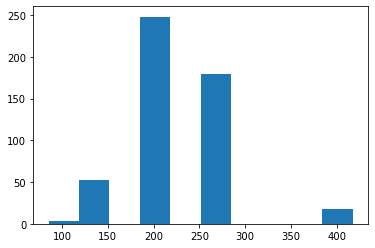

In [11]:
cv = GroupAwareKFold(n_splits=n_splits)
samples = shuffled_samples(len(X0_train),simulations)
est1 = fit_repeated_models(cv, m.estimator, m.parameters, samples, X0_train, y0_train)
plt.hist(extract_alpha(est1));

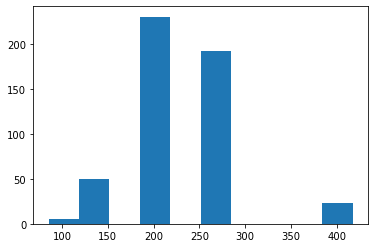

In [12]:
cv = KFold(n_splits=n_splits)
samples = shuffled_samples(len(X0_train),simulations)
est2 = fit_repeated_models(cv, m.estimator, m.parameters, samples, X0_train, y0_train)
plt.hist(extract_alpha(est2));

### Boostrapping

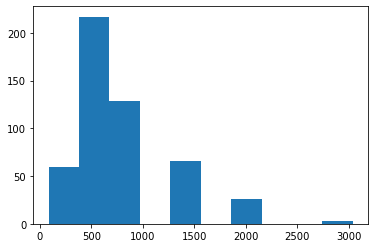

In [13]:
cv = GroupAwareKFold(n_splits=n_splits)
samples = bootstrap_samples(len(X0_train),simulations)
est3 = fit_repeated_models(cv, m.estimator, m.parameters, samples, X0_train, y0_train)
plt.hist(extract_alpha(est3));

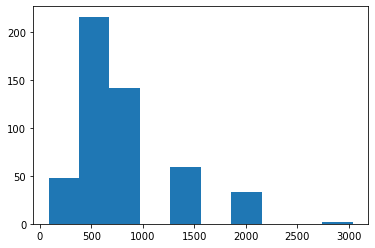

In [14]:
cv = GroupKFold(n_splits=n_splits)
samples = bootstrap_samples(len(X0_train),simulations)
est4 = fit_repeated_models(cv, m.estimator, m.parameters, samples, X0_train, y0_train)
plt.hist(extract_alpha(est4));

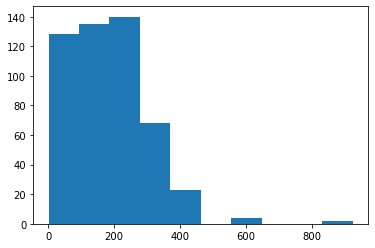

In [15]:
cv = KFold(n_splits=n_splits)
samples = bootstrap_samples(len(X0_train),simulations)
est5 = fit_repeated_models(cv, m.estimator, m.parameters, samples, X0_train, y0_train)
plt.hist(extract_alpha(est5));